In [2]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [3]:
df = pd.read_csv('./../../data/processed/ID_Y.csv')
# df = pd.read_csv('./../../data/processed/.csv')

sales = df.loc[df.IMPORT == 0].groupby(['ID', 'YEAR'])['VART'].sum().unstack()

sales = sales.loc[sales.sum(1).sort_values().index]

logsales = np.log10(sales)
demlogsales = logsales.subtract(logsales.mean(1), axis = 0)

sizes = sales.loc[sales.sum(1).sort_values().index].sum(1)

Q = 10
parts = pd.cut(sizes.cumsum()/sizes.sum(), Q, labels = range(Q)).sort_index()

In [160]:
info = sales.unstack().dropna().sort_values()
((info.cumsum()/info.sum())> .1).sum()/len(info)

0.050828622748016986

In [168]:
info.iloc[((info.cumsum()/info.sum())< .1).sum()].round(-5)

5800000.0

In [158]:
info.iloc[((info.cumsum()/info.sum())< .1).sum()].round(-5)

3400000.0

In [167]:
np.log10(5800000)

6.763427993562937

In [4]:
yqs = sales.groupby(parts).sum()
# yqs.T.cov().sum().sum()

In [5]:
X = yqs.sum()
E = X.mean()

print(np.log10(X).var()*(np.log(10)*E)**2)
print(yqs.T.cov().sum().sum())
print(X.var())

3.3370312602685465e+21
3.133103239847798e+21
3.133103239847797e+21


In [6]:
# Sq = yqs.mean(1).mean() # approx un sq que es el valor lineal medio de los qs

# Sq**2*np.log(10)**2*(np.log10(yqs).T.cov().sum().sum())
(yqs.sum().sum()/17/Q)**2*np.log(10)**2*(np.log10(yqs).T.cov().sum().sum())

3.408678822628621e+21

In [7]:
logsales = np.log10(sales)

micro_s = logsales.sub(logsales.mean(1), axis=0).unstack().std()
zero_shock = logsales.notna().multiply(logsales.mean(1), axis = 0).replace(0, np.nan)

# noise = np.power(10, zero_shock + simu_shocks) - np.power(10, zero_shock)

In [8]:
# common_R + noise_qs + base_qs - yqs == 0

In [9]:
import seaborn as sns
cm = sns.light_palette("green", as_cmap=True)


In [10]:
nqs = parts.value_counts().values
lognqs = np.log10(nqs)


In [11]:
## Same plot but bootstrapped. Also, allow smaller s.
out_list = []

n = 5
Q = 10

for m in range(n):
    print(m)
    for s in [.02, .05, .1, .25, .5]:

        df_bs = sales.sample(frac = .5)
        df_bs = df_bs.loc[df_bs.sum(1).sort_values().index] #sorting

        logsales = np.log10(df_bs)

        micro_s = logsales.sub(logsales.mean(1), axis=0).unstack().std()
        zero_shock = logsales.notna().multiply(logsales.mean(1), axis = 0).replace(0, np.nan)
        simu_shocks = (s/micro_s)*logsales.sub(logsales.mean(1), axis = 0)

        total = np.power(10, zero_shock + simu_shocks)
        base = np.power(10, zero_shock)
        noise = np.power(10, zero_shock + simu_shocks) - np.power(10, zero_shock)
        
        total['q'] = pd.cut(total.sum(1).cumsum(), Q, labels = range(Q))


        common_R = noise.groupby(total['q']).sum().median()
        # optional, broadcast to 2d Q x T
        common_R = pd.DataFrame(np.outer(np.ones(Q), common_R.values), columns=common_R.index)

        noise_qs = noise.groupby(total['q']).sum() - common_R
        base_qs = base.groupby(total['q']).sum()
        yqs = common_R + noise_qs + base_qs
        
        nqs = total['q'].value_counts().values
#         lognqs = np.log10(nqs)
        
        out = pd.concat([yqs.var(1), noise_qs.var(1), base_qs.var(1), common_R.var(1)], axis = 1)
        out.columns = ['yqs_var', 'noise_var', 'base_var', 'common_R_var']
        out['q'] = range(Q); out['m'] = m; out['nqs'] = nqs; out['s'] = s;

        out_list += [out]

0
1
2
3
4


In [12]:
bs_result = pd.concat(out_list)
# data = bs_result.groupby(['q', 's']).agg(['mean', 'std']).drop('m', axis = 1)
data = bs_result.groupby(['q', 's']).median().drop('m', axis = 1)

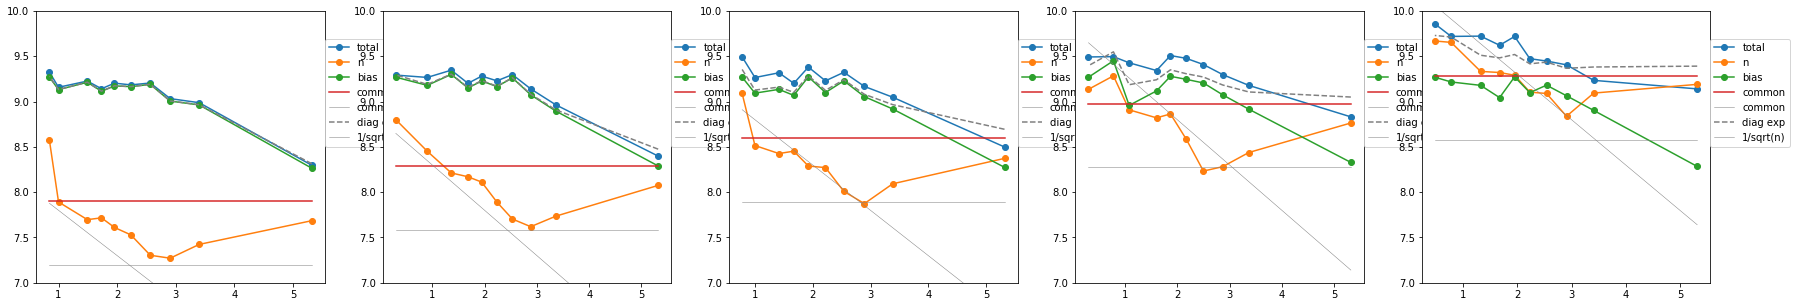

In [13]:
fig, axs = plt.subplots(1, 5, figsize = (30, 5))


for i, s in enumerate([.02, .05, .1, .25, .5]):
    ax = axs[i]
    data_s = data.loc[data.index.get_level_values('s') == s]
    lognqs = np.log10(data_s.nqs).values

    ax.plot(lognqs, np.log10(np.sqrt(data_s['yqs_var'].values)), marker = 'o', label = 'total') # actual std of quantiles
    ax.plot(lognqs, np.log10(np.sqrt(data_s['noise_var'].values)), marker = 'o', label = 'n') # std of statistical noise
    ax.plot(lognqs, np.log10(np.sqrt(data_s['base_var'].values)), marker = 'o', label = 'bias') # std of bias
    ax.plot(lognqs, np.log10(np.sqrt(data_s['common_R_var'].values)), label = 'common') # std of the common trend
    ax.plot(lognqs, np.log10(np.sqrt(data_s['common_R_var'].values) /5), label = 'common', lw = .5, c = '.5') # std of the common trend
    ax.plot(lognqs, np.log10(np.sqrt(data_s['common_R_var'].values + data_s['base_var'].values + data_s['noise_var'].values)), linestyle = '--', c = '.5', label = 'diag exp') # std of the common trend
    ax.plot(lognqs, .5*i + 8.3-lognqs/2, label = '1/sqrt(n)', lw = .5, c = '.5')
    ax.legend(loc = (1, .5))
    ax.set_ylim(7, 10)
plt.show()

In [14]:
## Same thing but I want no biases. So, I want an effective nq and use a lognormal > 3 CDF levels, over T = 17 as base on which to add shocks. Also, now the shocks will be randomised (within quantile?)

## Zero BIAS

### Load data

In [9]:
#### Moved to Experiment 5 notebook


# df = pd.read_csv('./../../data/processed/ID_Y.csv')
# # df = pd.read_csv('./../../data/processed/.csv')

# sales = df.loc[df.IMPORT == 0].groupby(['ID', 'YEAR'])['VART'].sum().unstack()
# sales = sales.loc[sales.sum(1).sort_values().index]

# logsales = np.log10(sales)
# demlogsales = logsales.subtract(logsales.mean(1), axis = 0)

# sizes = sales.loc[sales.sum(1).sort_values().index].sum(1)

# Q = 10
# parts = pd.cut(sizes.cumsum()/sizes.sum(), Q, labels = range(Q)).sort_index()

In [10]:
#### Moved to Experiment 5 notebook

# ## Effective Nq
# eff_nq = sales.groupby(parts).count().mean(1).round().astype(int)
# eff_nq

0    98643
1     4212
2     1414
3      635
4      319
5      168
6       92
7       46
8       17
9        5
dtype: int64

### Size dist Params

In [11]:
#### Moved to Experiment 5 notebook


# from scipy.stats import norm
# # from scipy.stats import norm
# # from scipy.stats import pareto
# from scipy.special import erf

# #  - Lognormal clipped x > 3. 
# sigma = 1.2810683494198207 # 1.3149476902828778
# mu = 4.536908110675739 # 4.470439741406725
# # 11.5% of guys that would be below the .3 threshold.
# z = (mu - 3)/sigma
# cum_th = 1 - .5*(1 + erf(z/np.sqrt(2)))

# # emp_nq_med = nq.groupby(level = 0).median()
# N = int(eff_nq.sum().round())

# N_ = int(round(N/(1 - cum_th))) # We use a larger N ..
# # From the theoretical N and the ppf we can know the theoretical quantiles
# x_logn_clip3 = np.array([norm.ppf(q, mu, sigma) for q in np.arange(0, 1, 1/N_) + .5/N_])
# x_logn_clip3 = x_logn_clip3[(-N - 1):-1]


# T = 17

In [18]:
# s0 = pd.Series(np.power(10, x_logn_clip3))

# s0_n = s0.groupby(pd.cut(s0.cumsum()/s0.sum(), Q, labels = range(Q))).count()
# bs_n = eff_nq.round(1)

# show = pd.concat([bs_n, s0_n], axis = 1); show.columns = ['Bootstrap nq', 'Lognormal >3 synthetic dist']
# show

,Bootstrap nq,Lognormal >3 synthetic dist
0,98643,99224
1,4212,3879
2,1414,1320
3,635,578
4,319,280
5,168,142
6,92,71
7,46,35
8,17,16
9,5,6


In [19]:
# simu_shocks = (s/micro_s)*logsales.sub(logsales.mean(1), axis = 0)

### Decomposition into Common shocks and noise

In [20]:

dem = logsales.sub(logsales.mean(1), axis = 0)
sample_shocks = dem.loc[dem.count(1) > 1].unstack().dropna() # (1.6 m real shocks)
micro_s = logsales.sub(logsales.mean(1), axis=0).unstack().std()
zero_shock = pd.DataFrame(pd.concat(T * [pd.Series(x_logn_clip3)], axis = 1))
zero_shock.columns = sales.columns

out_list = []

n = 50
Q = 10

for m in range(n):
    print(m)
    for s in [.02, .05, .1, .25, .5]:

#         df_bs = sales.sample(frac = .5)
#         df_bs = df_bs.loc[df_bs.sum(1).sort_values().index] #sorting

#         logsales = np.log10(sales)
        simu_shocks = pd.DataFrame((s/micro_s)*np.random.choice(sample_shocks.values, zero_shock.shape))
        simu_shocks.columns = sales.columns

#         micro_s = logsales.sub(logsales.mean(1), axis=0).unstack().std()
#         zero_shock = logsales.notna().multiply(logsales.mean(1), axis = 0).replace(0, np.nan)
        
#         simu_shocks = (s/micro_s)*logsales.sub(logsales.mean(1), axis = 0)

        total = np.power(10, zero_shock + simu_shocks)
        base = np.power(10, zero_shock)
        noise = np.power(10, zero_shock + simu_shocks) - np.power(10, zero_shock)
        
        total['q'] = pd.cut(total.sum(1).cumsum(), Q, labels = range(Q))

        common_R = noise.groupby(total['q']).sum().median()
        # optional, broadcast to 2d Q x T
        common_R = pd.DataFrame(np.outer(np.ones(Q), common_R.values), columns=common_R.index)

        noise_qs = noise.groupby(total['q']).sum() - common_R
        base_qs = base.groupby(total['q']).sum()
        yqs = common_R + noise_qs + base_qs
        
        nqs = total['q'].value_counts().values
#         lognqs = np.log10(nqs)
        
        out = pd.concat([yqs.var(1), noise_qs.var(1), base_qs.var(1), common_R.var(1)], axis = 1)
        out.columns = ['yqs_var', 'noise_var', 'base_var', 'common_R_var']
        out['q'] = range(Q); out['m'] = m; out['nqs'] = nqs; out['s'] = s;

        out_list += [out]

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49


In [21]:
bs_result = pd.concat(out_list)
# data = bs_result.groupby(['q', 's']).agg(['mean', 'std']).drop('m', axis = 1)
data = bs_result.groupby(['q', 's']).median().drop('m', axis = 1)

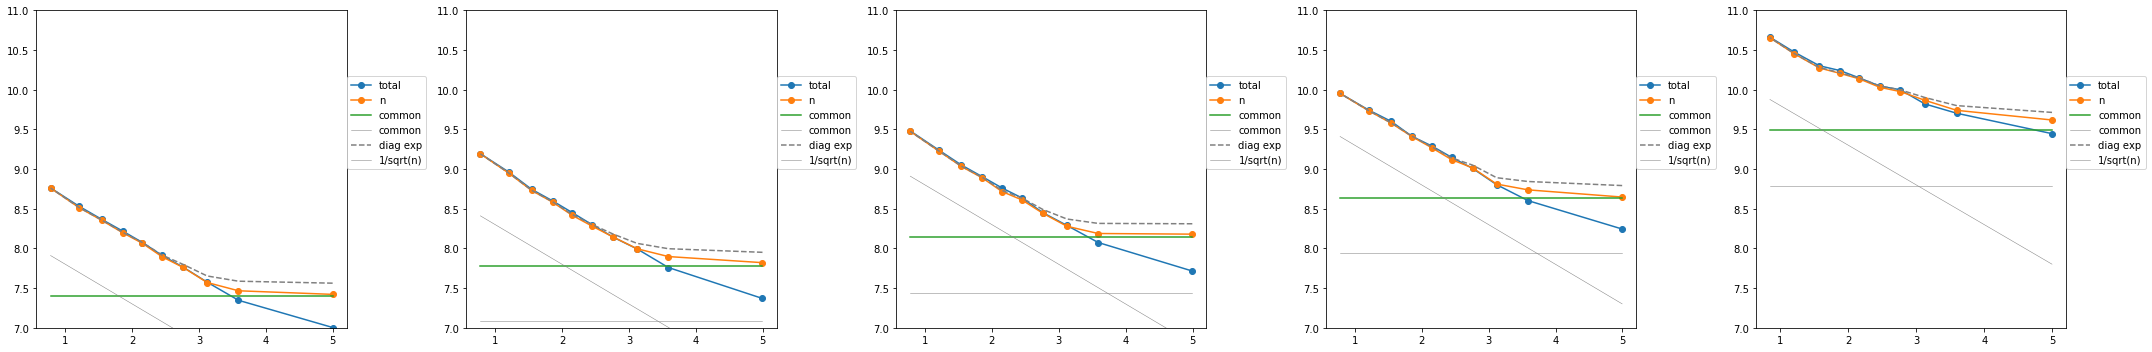

In [22]:
fig, axs = plt.subplots(1, 5, figsize = (30, 5))


for i, s in enumerate([.02, .05, .1, .25, .5]):
    ax = axs[i]
    data_s = data.loc[data.index.get_level_values('s') == s]
    lognqs = np.log10(data_s.nqs).values

    ax.plot(lognqs, np.log10(np.sqrt(data_s['yqs_var'].values)), marker = 'o', label = 'total') # actual std of quantiles
    ax.plot(lognqs, np.log10(np.sqrt(data_s['noise_var'].values)), marker = 'o', label = 'n') # std of statistical noise
#     ax.plot(lognqs, np.log10(np.sqrt(data_s['base_var'].values)), marker = 'o', label = 'bias') # std of bias
    ax.plot(lognqs, np.log10(np.sqrt(data_s['common_R_var'].values)), label = 'common') # std of the common trend
    ax.plot(lognqs, np.log10(np.sqrt(data_s['common_R_var'].values) /5), label = 'common', lw = .5, c = '.5') # std of the common trend
    ax.plot(lognqs, np.log10(np.sqrt(data_s['common_R_var'].values + data_s['base_var'].values + data_s['noise_var'].values)), linestyle = '--', c = '.5', label = 'diag exp') # std of the common trend
    ax.plot(lognqs, .5*i + 8.3-lognqs/2, label = '1/sqrt(n)', lw = .5, c = '.5')
    ax.legend(loc = (1, .5))
    ax.set_ylim(7, 11)
plt.tight_layout()
plt.show()

### Decomposition into only noise

In [5]:
T = 17

In [12]:
# ### Moved to Experiment 5 notebook


# dem = logsales.sub(logsales.mean(1), axis = 0)
# sample_shocks = dem.loc[dem.count(1) > 1].unstack().dropna() # (1.6 m real shocks)
# micro_s = logsales.sub(logsales.mean(1), axis=0).unstack().std()
# zero_shock = pd.DataFrame(pd.concat(T * [pd.Series(x_logn_clip3)], axis = 1))
# zero_shock.columns = sales.columns

# out_list = []

# n = 50
# Q = 10

# for m in range(n):
#     print(m)
#     for s in [.02, .05, .1, .25, .5]:

# #         df_bs = sales.sample(frac = .5)
# #         df_bs = df_bs.loc[df_bs.sum(1).sort_values().index] #sorting

# #         logsales = np.log10(sales)
#         simu_shocks = pd.DataFrame((s/micro_s)*np.random.choice(sample_shocks.values, zero_shock.shape))
#         simu_shocks.columns = sales.columns

#         total = np.power(10, zero_shock + simu_shocks)
#         base = np.power(10, zero_shock) # Is really frozen in this case
#         noise = np.power(10, zero_shock + simu_shocks) - np.power(10, zero_shock)
        
#         total['q'] = pd.cut(total.sum(1).cumsum(), Q, labels = range(Q))

#         noise_qs = noise.groupby(total['q']).sum()
#         base_qs = base.groupby(total['q']).sum()
#         yqs = noise_qs + base_qs
        
#         nqs = total['q'].value_counts().values
# #         lognqs = np.log10(nqs)
        
#         out = pd.concat([yqs.var(1), noise_qs.var(1), base_qs.var(1)], axis = 1)
#         out.columns = ['yqs_var', 'noise_var', 'base_var']
#         out['q'] = range(Q); out['m'] = m; out['nqs'] = nqs; out['s'] = s;

#         out_list += [out]

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49


In [15]:
# ### Moved to Experiment 5 notebook


# bs_result = pd.concat(out_list).reset_index(drop = True)
# # data = bs_result.groupby(['q', 's']).agg(['mean', 'std']).drop('m', axis = 1)
# data = bs_result.groupby(['q', 's']).median().drop('m', axis = 1)

# def percentile_lo (x): 
#     return np.percentile(x, q=10)
# def percentile_hi (x): 
#     return np.percentile(x, q=90)

# data_m = bs_result.groupby(['q', 's']).median().drop('m', axis = 1)
# data_lo = bs_result.groupby(['q', 's']).agg(percentile_lo).drop('m', axis = 1)
# data_hi = bs_result.groupby(['q', 's']).agg(percentile_hi).drop('m', axis = 1)

In [17]:
# ## Fit the 1/n

# fit_data = np.log10(data[['nqs', 'yqs_var']])

# for s in fit_data.index.get_level_values('s').unique():
#     fit_data_s = fit_data.loc[fit_data.index.get_level_values('s') == s]
#     fit_data_s = fit_data_s.loc[fit_data_s.nqs < 4]

#     x = fit_data_s.nqs
#     y = fit_data_s.yqs_var
#     z = np.polyfit(x, y, 1); p = np.poly1d(z);
    
#     print(s, p/2)

In [ ]:
### Load from Experiment 5. Simple var vs nq, s. (s)

data = pd.read_csv('./')

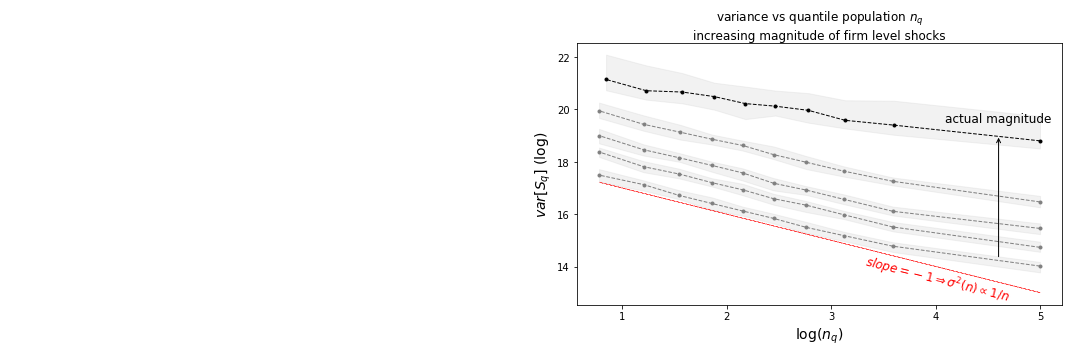

In [69]:
fig, axs = plt.subplots(1, 2, figsize = (15, 5))
axs[0].set_axis_off()
ax = axs[1]

for i, s in enumerate([.02, .05, .1, .25, .5]):
    data_s = data.loc[data.index.get_level_values('s') == s]
    lognqs = np.log10(data_s.nqs).values

#     ax.plot(lognqs, np.log10(np.sqrt(data_s['yqs_var'].values)), marker = 'o', label = 'total') # actual std of quantiles
    c = '.5';
    if s == .5: c = 'k'
    ax.plot(lognqs, np.log10(data_m.loc[data_m.index.get_level_values('s') == s]['noise_var']), marker = '.', c = c, lw = 1, linestyle = '--') # std of statistical noise

    ax.fill_between(lognqs, np.log10(data_hi.loc[data_hi.index.get_level_values('s') == s]['noise_var']), 
                                   np.log10(data_lo.loc[data_lo.index.get_level_values('s') == s]['noise_var']), color = '.8', alpha = .25, label = 'common_shocks_std')

    
    ax.plot(lognqs, 18-lognqs, label = '1/sqrt(n)', lw = .5, c = 'r', linestyle = ':')
#     ax.legend(loc = (1, .5))
#     ax.set_ylim(7, 11)

text = ax.annotate(xy = (3.3, 14), s = r'$ {slope} = -1 \Rightarrow \sigma^2(n) \propto 1/n $', fontsize = 12, color = 'r')
text.set_rotation(-14)
ax.annotate("", xy=(4.6, 19), xytext=(4.6, 14.3), arrowprops=dict(arrowstyle="->"), )
text = ax.annotate(xy = (4.6, 19.5), s = 'actual magnitude', ha='center', fontsize = 12, color = 'k')


plt.title(r'variance vs quantile population $n_q$'
          "\n"
          'increasing magnitude of firm level shocks')

plt.ylabel(r'$var[S_q]$ '+'(log)', fontsize = 14)
plt.xlabel(r'$\log(n_q)$', fontsize = 14)
plt.tight_layout()
plt.savefig('./../../../WRITING/paper1_writing/figures/var_nq.png')
plt.show()

In [29]:
# xx

In [30]:
# total =  quantile bases: [ np.power(10, zero_shock) ]  +  quantile noises: [ np.power(10, zero_shock + simu_shocks) - np.power(10, zero_shock) ] = line + shocks + quantiles

In [31]:
# total = np.power(10, zero_shock + simu_shocks)
# base = np.power(10, zero_shock)
# noise = np.power(10, zero_shock + simu_shocks) - np.power(10, zero_shock)

# total_q = total.groupby(df_bs['q']).sum()
# base_q = base.groupby(df_bs['q']).sum()
# noise_q = noise.groupby(df_bs['q']).sum()

# q = 5
# print(total_q.iloc[q].var())
# print(pd.concat([noise_q.iloc[q], base_q.iloc[q]], axis = 1).cov().sum().sum())

# for q in range(Q):
#     print(q)
#     (( np.power(10, zero_shock + simu_shocks)).groupby(total['q']).sum()).iloc[q].plot()#.T.plot(legend = False)

#     (np.power(10, zero_shock).groupby(total['q']).sum()).iloc[q].plot()#.T.plot(legend = False)

#     ((np.power(10, zero_shock + simu_shocks) - np.power(10, zero_shock)).groupby(total['q']).sum()).iloc[q].plot(linestyle = '--')#.T.plot(legend = False)
#     plt.ylim(0, 2.5e10)

#     plt.show()

In [32]:
## Non scaled, sanity check.

In [33]:
# out_list = []
qs_bs_list = []
parts_bs_list = []
# nq_list = []
# trend_std_list = []

n = 50
Q = 10

for m in range(n):

    df_bs = sales.sample(frac = .5)
    df_bs = df_bs.loc[df_bs.sum(1).sort_values().index] #sorting

    df_bs['q'] = pd.cut(df_bs.sum(1).cumsum(), Q, labels = range(Q))

    nq = df_bs.groupby('q').count().mean(1) ## Effective nq
#     nq = df_bs.q.value_counts()  ## Total count n

    df_bs = df_bs.groupby('q').sum()

    common_trend = df_bs.median()

    x = np.log10(common_trend).index.astype(int).values
    y = np.log10(common_trend).values
    z = np.polyfit(x, y, 1); p = np.poly1d(z);

    exp_curve = pd.Series(np.power(10, p(x)), index = x)

#         df_bs = df_bs/(.5 * exp_curve)
    shocks = common_trend/exp_curve
    df_bs = df_bs/(shocks*exp_curve) # == df_bs/common_trend

    parts_bs_2 = pd.concat([exp_curve, shocks, df_bs.sum()], axis = 1).T
    parts_bs_2['m'] = m; parts_bs_2['s'] = s
    parts_bs_list += [parts_bs_2]


    df_bs['nq'] = nq; df_bs['m'] = m; df_bs['s'] = s;
    qs_bs_list += [df_bs]

#         trend_std_list += [np.log10(common_trend/np.power(10, p(x))).std()]


parts_bs_2 = pd.concat(parts_bs_list)
qs_bs_2 = pd.concat(qs_bs_list)

In [34]:

## Microshocks

demlogsales['parts'] = parts
std_data = demlogsales.loc[demlogsales.iloc[:, :-1].count(1) > 1]
std_data.reset_index().set_index(['ID', 'parts']).stack().groupby(level = 'parts').std()


# Un array de donde samplear shocks empiricos.
emp_shocks = std_data.reset_index().set_index(['ID', 'parts']).stack().values
len(emp_shocks)

1615735

In [35]:
# # BS for sorted quantile partitions
# n = 50
# out = []

# for m in range(n):
#     df_bs = sales.sample(frac = .5)
#     df_bs = df_bs.loc[df_bs.sum(1).sort_values().index] #sorting
#     df_bs['q'] = pd.cut(df_bs.sum(1).cumsum(), Q, labels = range(Q))

# #     nq = df_bs.groupby('q').count().mean(1) ## Effective nq
# #     nq = df_bs.q.value_counts()  ## Total count n

#     df_bs = df_bs.groupby('q').sum()
#     out += [df_bs]
    
# bs_data = pd.concat(out)

# demedianed_log10 = np.log10(bs_data/pd.concat(n*[bs_data.groupby(level = 0).median()]))
# # var_nq = pd.concat([demedianed_log10.var(1), nq], axis = 1); var_nq.columns = ['var', 'nq']
# # quantile shocks

# qshocks = demedianed_log10.diff(axis = 1).stack().reset_index()
# # qshocks['bin'] = pd.cut(qshocks[0], np.arange(-.1, .1, .001))
# qshocks['bin'] = pd.cut(qshocks[0], np.arange(-.1, .1, .001))

# qshocks_hist = pd.DataFrame(qshocks.groupby(['bin', 'q']).size().unstack())

# qshocks_hist.rolling(6, center = True).mean().plot(figsize = (7, 5), marker = '.')
# plt.yscale('log')
# plt.show()


In [36]:
# BS for sorted quantile partitions
n = 50
out = []

for m in range(n):
    df_bs = sales.sample(frac = .5)
    df_bs = df_bs.loc[df_bs.sum(1).sort_values().index] #sorting
    df_bs['q'] = pd.cut(df_bs.sum(1).cumsum(), Q, labels = range(Q))

#     nq = df_bs.groupby('q').count().mean(1) ## Effective nq
#     nq = df_bs.q.value_counts()  ## Total count n

    df_bs = df_bs.groupby('q').sum()
    out += [df_bs]
    
bs_data = pd.concat(out)

demedianed_log10 = np.log10(bs_data/pd.concat(n*[bs_data.groupby(level = 0).median()]))
qshocks = demedianed_log10.diff(axis = 1).stack().reset_index()
qshocks['bin'] = pd.cut(qshocks[0], np.arange(-.1, .1, .001))


# BS for sorted quantile partitions
n = 50
out = []

for m in range(n):
    df_bs = sales.sample(frac = .5)
#     df_bs = df_bs.loc[df_bs.sum(1).sort_values().index] #sorting
    df_bs['q'] = pd.cut(df_bs.sum(1).cumsum(), Q, labels = range(Q))
    df_bs = df_bs.groupby('q').sum()
    out += [df_bs]
    
bs_data_unsort_q = pd.concat(out)

demedianed_log10 = np.log10(bs_data_unsort_q/pd.concat(n*[bs_data_unsort_q.groupby(level = 0).median()]))
qshocks2 = demedianed_log10.diff(axis = 1).stack().reset_index()
qshocks2['bin'] = pd.cut(qshocks2[0], np.arange(-.1, .1, .001))



In [127]:
sales.sum().sum()

5990942258100.0

In [125]:
for l in range(4):
    ## BS for Aggregate

    n = 20

    lo_agg = []
    hi_agg = []
    for m in range(n):
        df_bs = sales.sample(frac = .5)
        df_bs.sum()

        agg = np.log10(df_bs.sum()/df_bs.sum().mean())

        lo_agg += [agg.quantile(.1)]
        hi_agg += [agg.quantile(.9)]

    lo_agg = np.array(lo_agg).mean()
    hi_agg = np.array(hi_agg).mean()

    ## Firm sales xlims come from other notebook

    print(lo_agg)
    print(hi_agg)

-0.09995373802615375
0.07597587287253647
-0.10215232760330835
0.07799151303392957
-0.1125449210292007
0.08268307595724819
-0.10821954856090168
0.07853569036438753


## Log Approximation

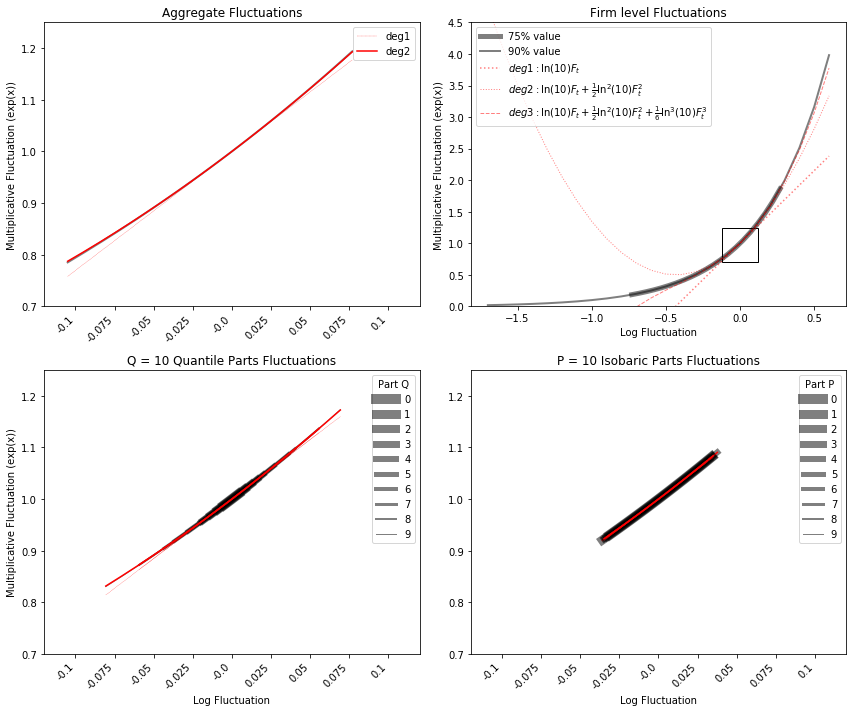

In [115]:
import matplotlib.patches as patches
fig, axs = plt.subplots(2, 2, figsize = (12, 10))


## Aggregate
ax = axs[0][0]
ax.set_title('Aggregate Fluctuations')
x = np.arange(lo_agg, hi_agg, 0.001)
y = np.power(10, x)
ax.plot(x, y, label = '', lw = 2, alpha = .5, color = 'k')
ax.plot(x, np.log(10) * (x) + 1, c = 'r', linestyle = '--', lw = .25, label = 'deg1')
ax.plot(x, (np.log(10) * (x))**2/2 + np.log(10) * (x) + 1, c = 'r', label = 'deg2')
ax.set_xlim(-.12, .12)
ax.set_xticks(np.arange(-.1, .125, .025))
ax.set_xticklabels(np.round(ax.get_xticks(), 3), rotation=45, ha = 'right')
ax.set_ylim(.7, 1.25)
ax.legend()
ax.set_ylabel('Multiplicative Fluctuation (exp(x))')



### Firm level
ax = axs[0][1]
ax.set_title('Firm level Fluctuations')
# half_nominal_measure_l = df_demlog_nominal_shrink.loc[df_demlog_nominal_shrink['gap'].cumsum()/df_demlog_nominal_shrink['gap'].sum() < .25].demlog.max()
# half_nominal_measure_r = df_demlog_nominal_growth.loc[df_demlog_nominal_growth['gap'].cumsum()/df_demlog_nominal_growth['gap'].sum() < .75].demlog.max()

x90 = np.arange(-1.7, 0.7, .1)
x75 = np.arange(-.73, 0.32, .05)  # Only 25% of the value in added in shocks smaller than this, 25% of the value in added in shocks larger than this

ax.plot(x75, np.power(10, x75), lw = 5, alpha = .5, color = 'k', label = '75% value')
ax.plot(x90, np.power(10, x90), lw = 2, alpha = .5, color = 'k', label = '90% value')

ax.plot(x90, 1 + np.log(10)*x90, linestyle = ':', alpha = .5, c = 'r', label = r'$deg 1: \ln(10) F_t$')
ax.plot(x90, 1 + np.log(10)*x90 + (np.log(10)*x90)**2/2, linestyle = ':', alpha = .5, c = 'r', lw =1, label = r'$deg 2: \ln(10) F_t + \frac{1}{2}\ln^2(10) F^2_t $')
ax.plot(x90, 1 + np.log(10)*x90 + (np.log(10)*x90)**2/2 + (np.log(10)*x90)**3/6, linestyle = '--', alpha = .5, c = 'r', lw =1, label = r'$deg3: \ln(10) F_t + \frac{1}{2}\ln^2(10) F^2_t +  \frac{1}{6}\ln^3(10) F^3_t$')


# Create a Rectangle patch
rect = patches.Rectangle((-.12, .7), .12 - (-.12), 1.25 - .7,linewidth=1,edgecolor='k',facecolor='none')
ax.add_patch(rect)

ax.legend(loc = 'upper left')
ax.set_ylim(0, 4.5)
ax.set_ylabel('Multiplicative Fluctuation (exp(x))')
ax.set_xlabel('Log Fluctuation')

### Sorted quantile partition

lo_q = qshocks.groupby('q')[0].quantile(.1)
hi_q = qshocks.groupby('q')[0].quantile(.9)

ax = axs[1][0]
ax.set_title('Q = 10 Quantile Parts Fluctuations')
for q in range(Q):
    x = np.arange(lo_q[q], hi_q[q], 0.001)
    y = np.power(10, x)
    ax.plot(x, y, label = q, lw = 10 - q, alpha = .5, color = 'k')
    ax.plot(x, np.log(10) * (x) + 1, c = 'r', linestyle = '--', lw = .25)
    ax.plot(x, (np.log(10) * x)**2/2 + np.log(10) * x + 1, c = 'r')
    
ax.set_xlim(-.12, .12)
ax.set_xticks(np.arange(-.1, .125, .025))
ax.set_xticklabels(np.round(ax.get_xticks(), 3), rotation=45, ha = 'right')
ax.set_ylim(.7, 1.25)
ax.legend(title = 'Part Q')
ax.set_ylabel('Multiplicative Fluctuation (exp(x))')
ax.set_xlabel('Log Fluctuation')


### Unsorted quantile partition

lo_q = qshocks2.groupby('q')[0].quantile(.1)
hi_q = qshocks2.groupby('q')[0].quantile(.9)

ax = axs[1][1]
ax.set_title('P = 10 Isobaric Parts Fluctuations')
for q in range(Q):
    x = np.arange(lo_q[q], hi_q[q], 0.001)
    y = np.power(10, x)
    ax.plot(x, y, label = q, lw = 10 - q, alpha = .5, color = 'k')
    ax.plot(x, np.log(10) * (x) + 1, c = 'r', linestyle = '--', lw = .25)
    ax.plot(x, (np.log(10) * x)**2/2 + np.log(10) * x + 1, c = 'r')
ax.set_xlim(-.12, .12)
ax.set_xticks(np.arange(-.1, .125, .025))
ax.set_xticklabels(np.round(ax.get_xticks(), 3), rotation=45, ha = 'right')
ax.set_ylim(.7, 1.25)
ax.legend(title = 'Part P')
ax.set_xlabel('Log Fluctuation')

plt.tight_layout()
plt.savefig('./../../../WRITING/paper1_writing/figures/series_approx.png')
plt.show()

In [ ]:

# data = qshocks_hist.rolling(6, center = True).mean()
# data = data.loc[[-.05 < m.mid < .05 for m in data.index]]

# quad_params = []

# for q in range(Q):
#     x = [m.mid for m in data[q].dropna().index]
#     y = data[q].dropna().values
#     z = np.polyfit(x, y, 2)
#     p = np.poly1d(z)
# #     print(p)
#     quad_params += [z]
    
# quad_params = np.array(quad_params)


# # NQs from bootstrap
# var_nq['m'] = [i//Q for i in range(n*Q)]
# nq = var_nq.reset_index().set_index(['q', 'm'])['nq'].unstack().median(1)


# fig, axs = plt.subplots(1, 2, figsize = (16, 5))

# ax = axs[0]
# ax.plot(range(Q), -quad_params[:, 1]/(2*quad_params[:, 0]), label = 'mu_q')
# ax.plot(range(Q), 1/np.sqrt(-2*quad_params[:, 0]), marker = '.', label = 'sigma_q')
# ax.set_xlabel('q'); ax.set_ylabel('log pts')
# ax.axhline(0, c = '.5', linestyle = '--')
# ax.legend()


# ax = axs[1]
# ax.plot(np.log10(nq.values), -quad_params[:, 1]/(2*quad_params[:, 0]), label = 'mu_q')
# ax.plot(np.log10(nq.values), 1/np.sqrt(-2*quad_params[:, 0]), marker = '.', label = 'sigma_q')
# ax.set_xlabel('log_n'); ax.set_ylabel('log pts')
# ax.axhline(0, c = '.5', linestyle = '--')
# ax.legend()

# plt.show()